In [1]:
import os

os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
from urbanstats.games.quiz_analysis import get_full_statistics, questions
from urbanstats.games.quiz import display_question, quiz_is_guaranteed_past

In [4]:
plt.rcParams["font.family"] = "monospace"

In [5]:
result = get_full_statistics(after_problem=49, debug=False)
num_users_by_problem = result.groupby("problem").count().user_id
means = result[["problem", "score", *questions]].groupby("problem").mean()

/home/kavi/census-centroid-blocks/population_density/urbanstats/games/quiz_analysis.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.idxmax is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result.loc[result.groupby("time").idxmax().problem, "last_in_batch"] = 1


In [6]:
def line_histogram(offs, weights=None, dx=0.5):
    bin_sides = offs // dx * dx
    bins = np.arange(bin_sides.min(), bin_sides.max() + 1, dx)
    #     plt.hist(offs, bins=bins, alpha=0.5, label=f"J{time}; total={offs.shape[0]}")
    y, be = np.histogram(offs, weights=weights, bins=bins)
    x = (be[1:] + be[:-1]) / 2
    return x, y

In [7]:
def plot():
    plt.figure(dpi=200, facecolor="white")
    for time in range(result.problem.max() - 2, result.problem.max() + 1):
        offs = result[(result.problem == time) & (result.last_in_batch == 1)].offset
        plt.plot(*line_histogram(offs), label=f"J{time}; total={offs.shape[0]}", lw=0.5)
    plt.xticks(rotation=90)
    plt.xlabel("Hours after EDT release")
    plt.ylabel("Frequency")
    lo, hi = plt.xlim()
    lo = lo // 4 * 4
    hi = hi // 4 * 4 + 4
    plt.xticks(np.arange(lo, hi + 4, 4))
    plt.grid()
    # plt.axvline(1.5, color="red", lw=0.5, label="Graph Crimes Post")
    # for h in 0, 1, 2, 3, 24, 25, 26, 27:
    #     plt.axvline(h, color="black", lw=0.5)
    plt.legend()
    plt.show()

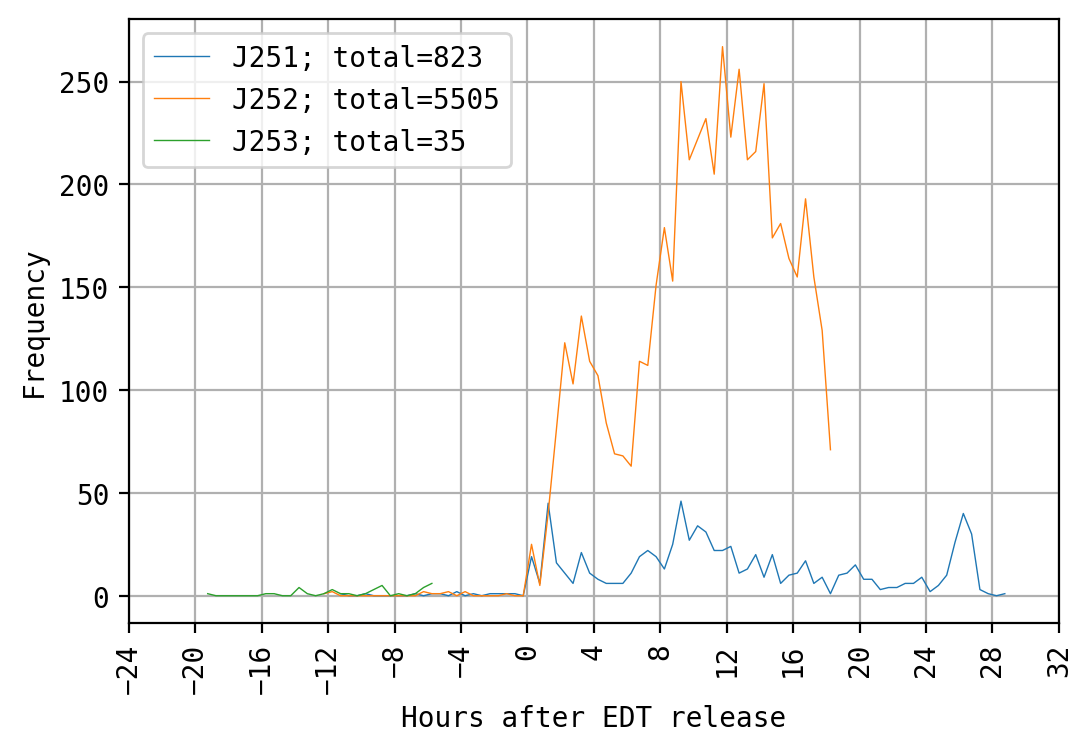

In [8]:
plot()

<ipython-input-9-f45058fa6c4d>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result[(result.offset < time) & (result.problem <= today)]


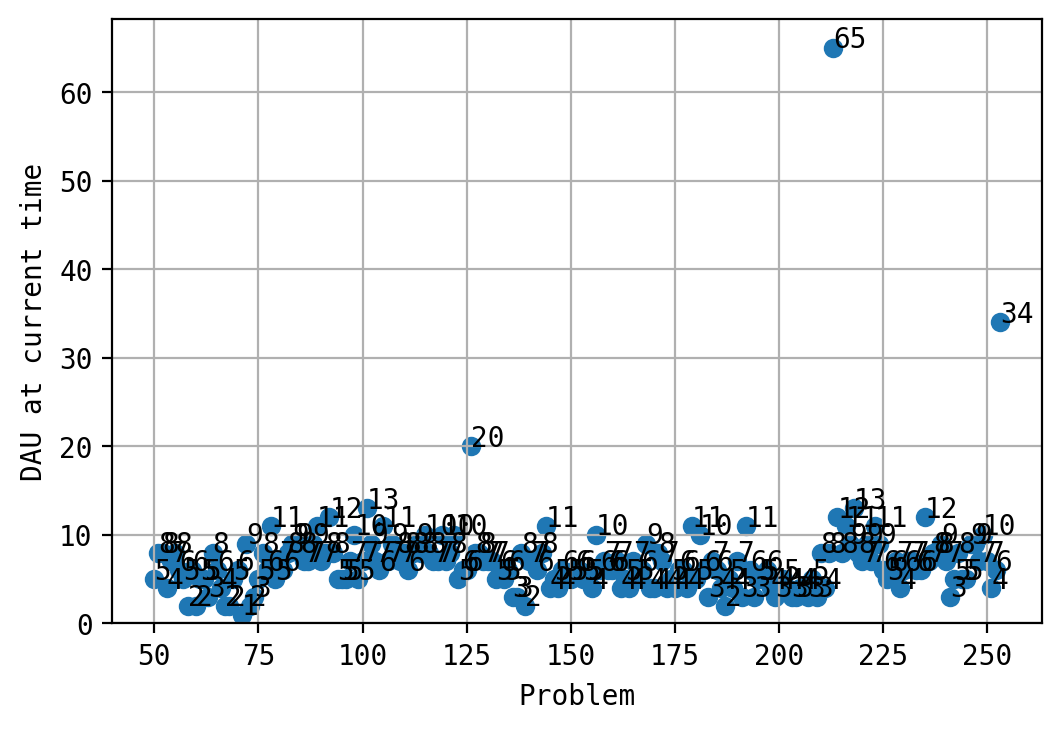

In [9]:
count_by_day = (
    result[["problem", "last_in_batch"]]
    .groupby("problem")
    .sum()
    .rename(columns={"last_in_batch": "c"})
)
today = count_by_day.index[count_by_day.c > 30].max()
time = result[result.problem == today].offset.max()
at_time = (
    result[(result.offset < time) & (result.problem <= today)]
    .groupby("problem")
    .sum()
    .last_in_batch
)
plt.figure(dpi=200)
plt.scatter(at_time.index, at_time)
for x in at_time.index:
    plt.text(s=int(at_time[x]), x=x, y=at_time[x])
plt.xlabel("Problem")
plt.ylabel("DAU at current time")
plt.ylim(0, plt.ylim()[1])
plt.grid()
plt.show()

In [10]:
def plot_juxtastat_times(compute_y, formatter=lambda x: f"{x:.0f}%", dx=0.5):
    plt.figure(dpi=200, facecolor="white")
    pre_today = result[(result.problem < today) & (result.last_in_batch == 1)].copy()
    time_all = pre_today.offset
    weights = 1 / pre_today.groupby("problem").count().user_id[pre_today.problem]
    weights /= weights.sum()
    pre_today["weight"] = list(weights)
    bins = np.arange(-14, 28 + dx, dx)
    y = []
    for xs, xe in zip(bins[:-1], bins[1:]):
        tab = pre_today[(xs <= pre_today.offset) & (pre_today.offset < xe)]
        y += [compute_y(tab)]
    x = (bins[1:] + bins[:-1]) / 2
    y = np.array(y)
    ymax = np.nanmax(y)
    # x, y = line_histogram(time_all, weights=100 * weights, dx=0.5)
    plt.plot(x, y, lw=0.5, marker=".", color="black")
    plt.xlabel("Time in day [EDT]")
    plt.xticks([-12, -6, 0, 6, 12, 18, 24, 6])

    def span(s, e, color, name):
        plt.axvspan(s, e, alpha=0.5, color=color)
        count = compute_y(pre_today[(s <= time_all) & (time_all < e)])
        format_count = formatter(count)
        plt.text(
            x=(s + e) / 2, y=ymax * 1.1, s=f"{name}\n({format_count})", ha="center"
        )

    span(-14, 0, "#f96d6d", "Non_US")
    span(0, 6, "#5a7dc3", "Night")
    span(6, 18, "#8ac35a", "Day")
    span(18, 28, "#4e525a", "Last Minute")

    plt.ylim(0, ymax * 1.3)
    plt.grid()

Text(0, 0.5, 'User concentration in this time [%]')

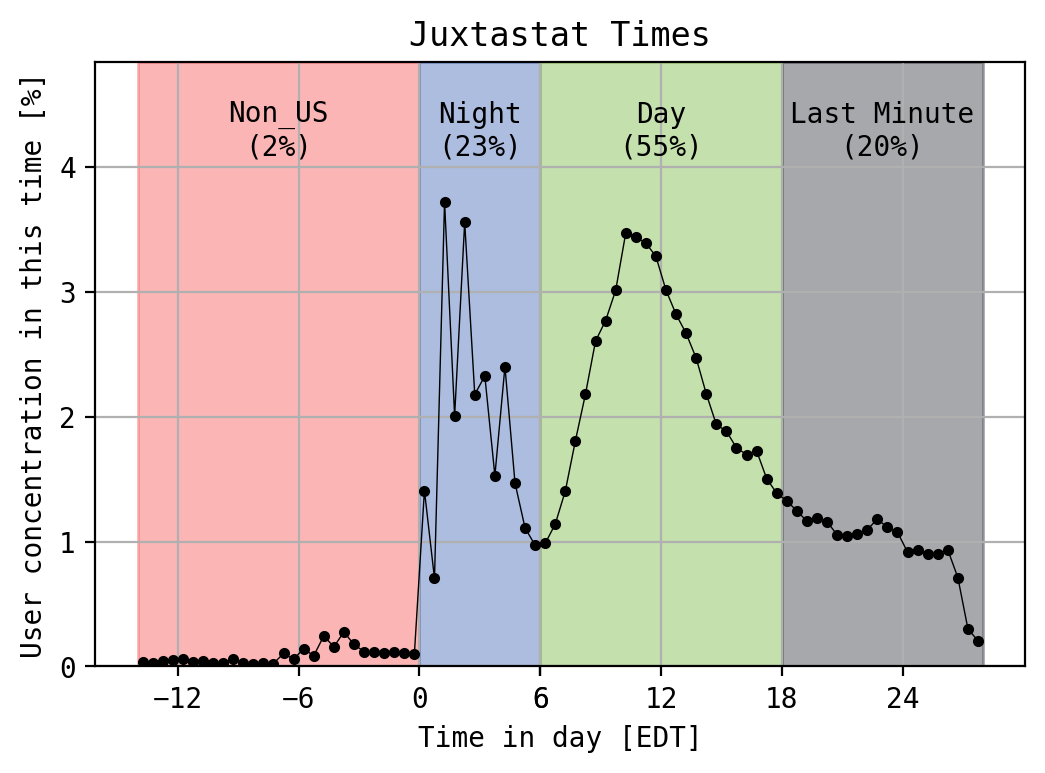

In [11]:
plot_juxtastat_times(compute_y=lambda tab: tab["weight"].sum() * 100)
plt.title("Juxtastat Times")
plt.ylabel("User concentration in this time [%]")

Text(0, 0.5, 'mean score this time')

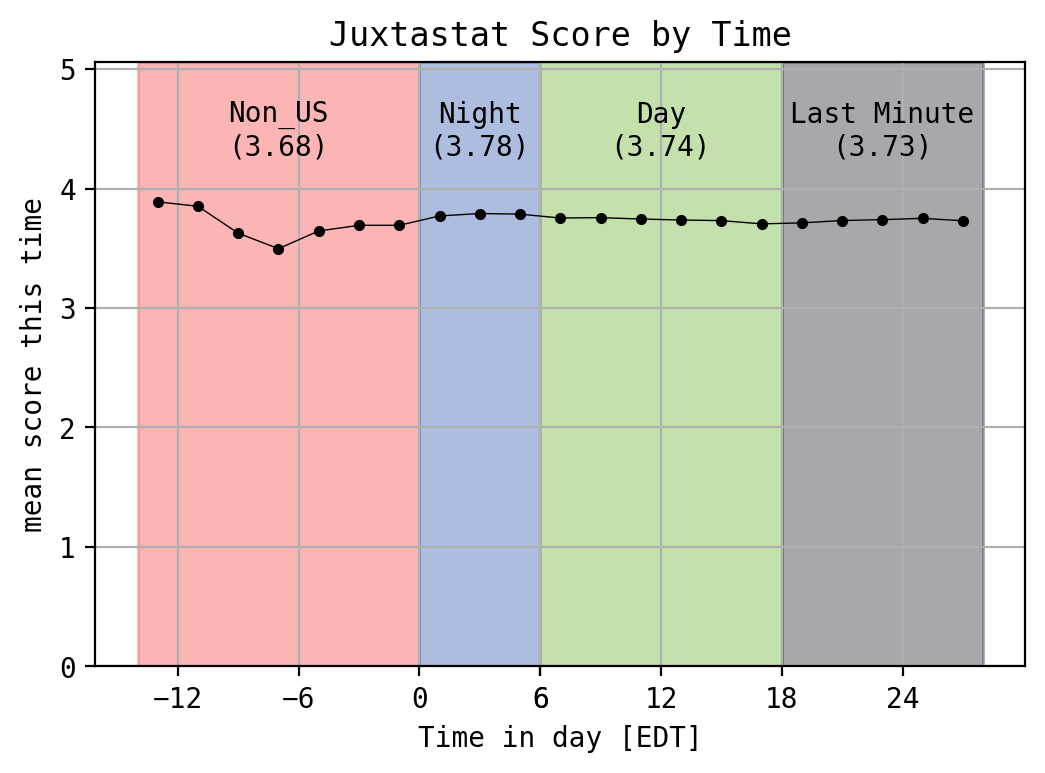

In [12]:
plot_juxtastat_times(
    compute_y=lambda tab: (tab["weight"] * tab["score"]).sum() / tab["weight"].sum()
    if tab["weight"].sum()
    else np.nan,
    formatter=lambda x: f"{x:.2f}",
    dx=2,
)
plt.title("Juxtastat Score by Time")
plt.ylabel("mean score this time")

In [13]:
is_valid_day = lambda x: quiz_is_guaranteed_past(x) is None and x > 50

In [14]:
mask = [is_valid_day(x) for x in num_users_by_problem.index]
xs, ys = num_users_by_problem.index[mask], num_users_by_problem[mask]

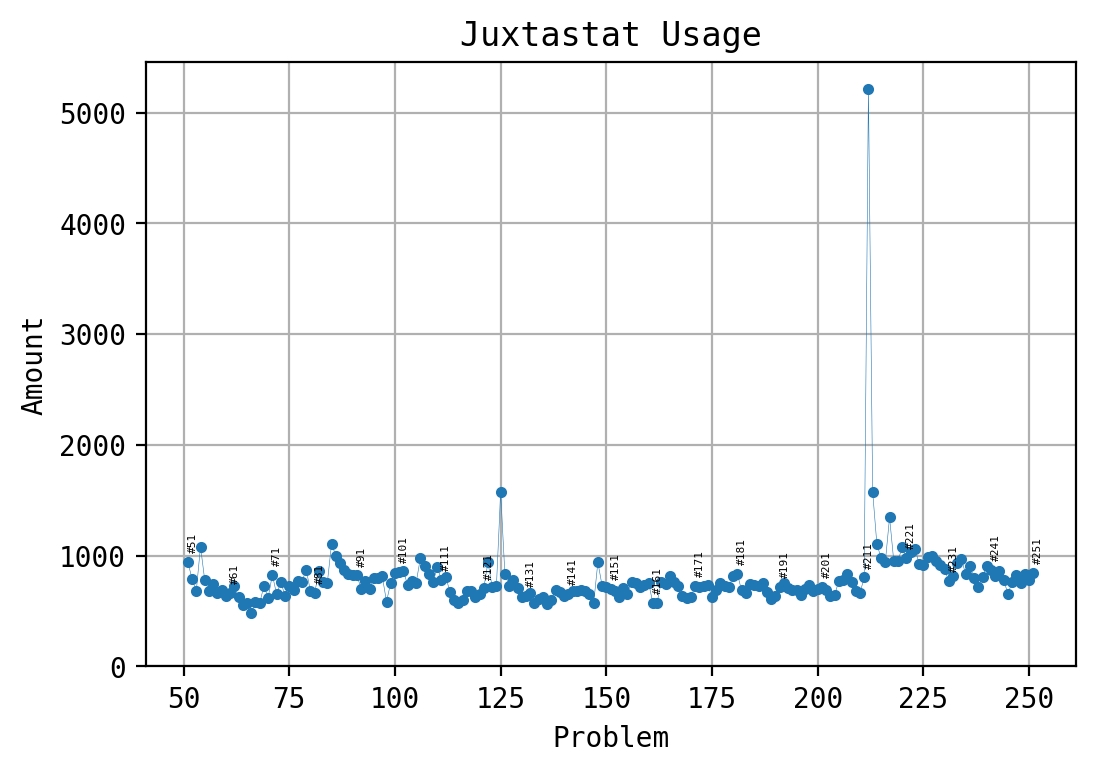

In [15]:
def plot_usage():
    plt.figure(dpi=200, facecolor="white")
    plt.title("Juxtastat Usage")
    plt.plot(xs, ys, marker=".", lw=0.2)
    plt.xlabel("Problem")
    plt.ylabel("Amount")
    plt.ylim(0, plt.ylim()[1])
    plt.grid()
    for x, y in list(zip(xs, ys))[::-10]:
        plt.text(x=x, y=y + 100, s=f"#{x}", fontsize=4, rotation=90)
plot_usage()

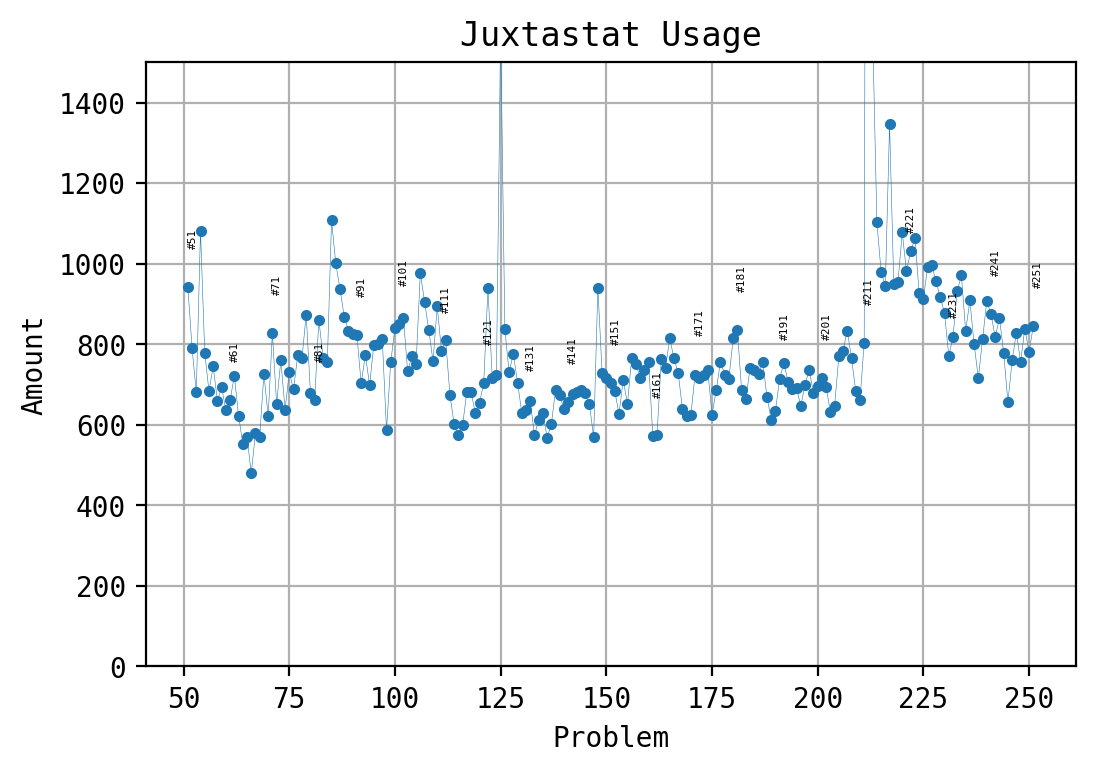

In [16]:
plot_usage()
plt.ylim(0, 1500)
plt.show()

In [17]:
def for_dow(dow):
    return ys[(xs - 1) % 7 == dow]

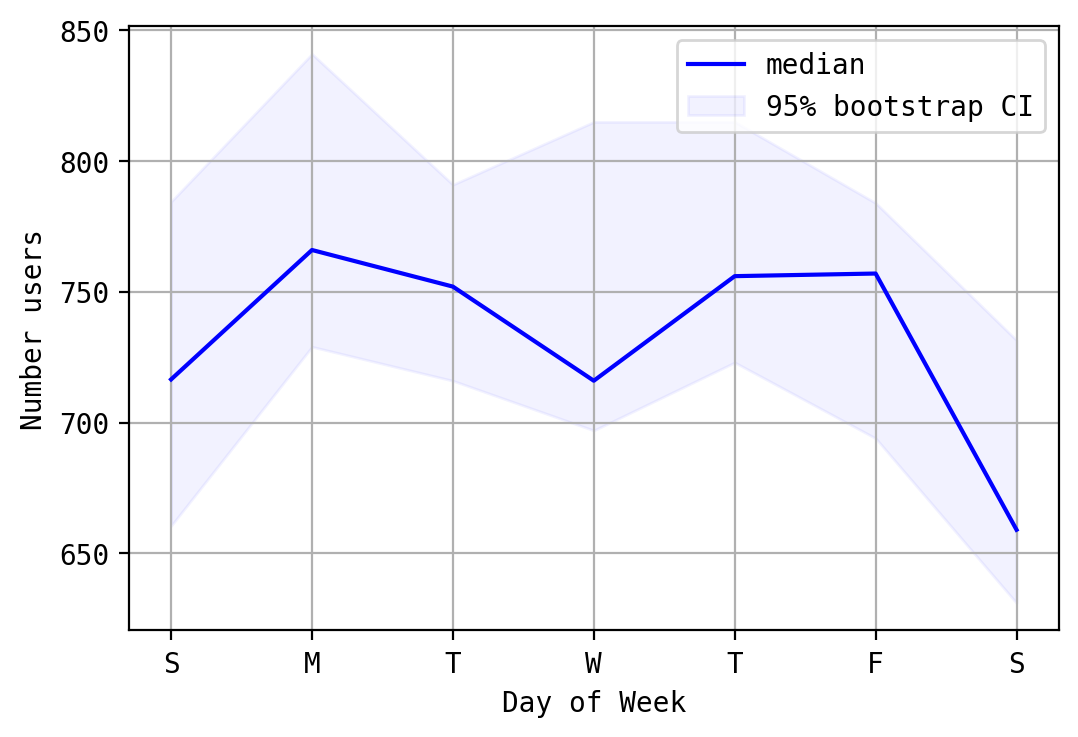

In [18]:
def summary_stats(ys):
    bootstrap = np.median(np.random.RandomState(0).choice(ys, replace=True, size=(10000, ys.shape[0])), 1)
    return np.percentile(bootstrap, [2.5, 50, 97.5])
lo, me, hi = np.array([summary_stats(for_dow(dow)) for dow in range(7)]).T
plt.figure(dpi=200)
x = np.arange(7)
plt.plot(x, me, color="blue", label="median")
plt.fill_between(x, lo, hi, color="blue", alpha=0.05, label="95% bootstrap CI")
plt.xticks(x, list("SMTWTFS"))
plt.ylabel("Number users")
plt.xlabel("Day of Week")
plt.legend()
plt.grid()
plt.show()

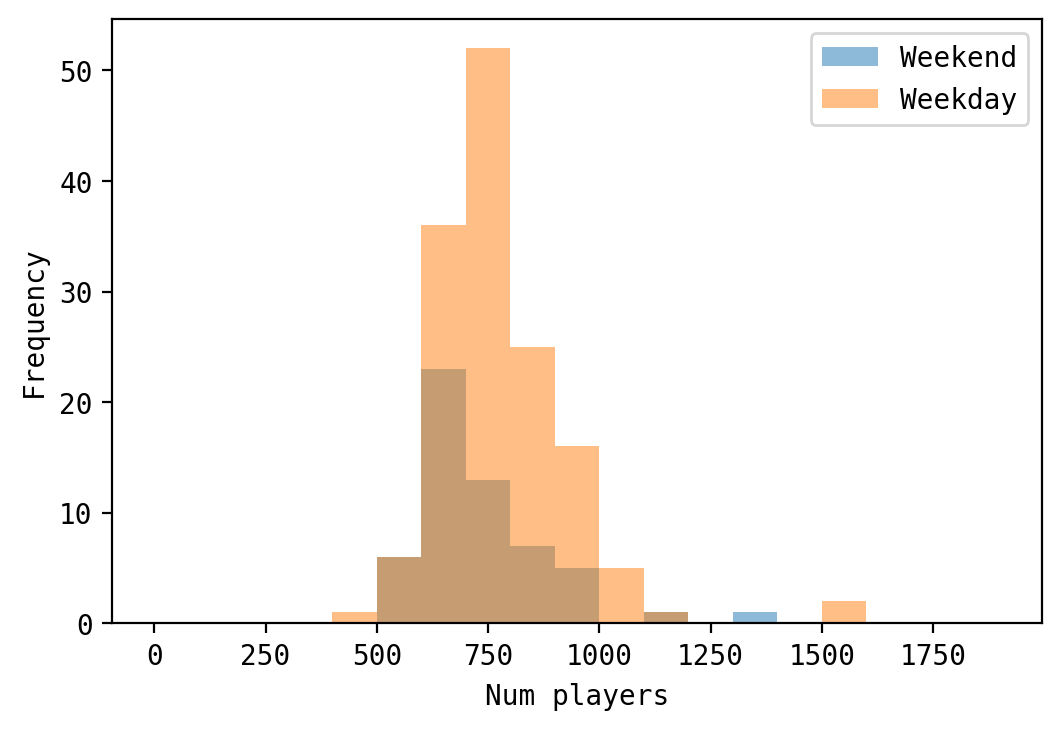

In [19]:
plt.figure(dpi=200, facecolor="white")
bins = np.arange(0, 2000, 100)
plt.hist([x for dow in [0, 6] for x in for_dow(dow)], bins=bins, alpha=0.5, label="Weekend")
plt.hist([x for dow in range(1, 1 + 5) for x in for_dow(dow)], bins=bins, alpha=0.5, label="Weekday")
plt.legend()
plt.xlabel("Num players")
plt.ylabel("Frequency")
plt.show()

In [20]:
import sklearn.linear_model

0.005054424059911189


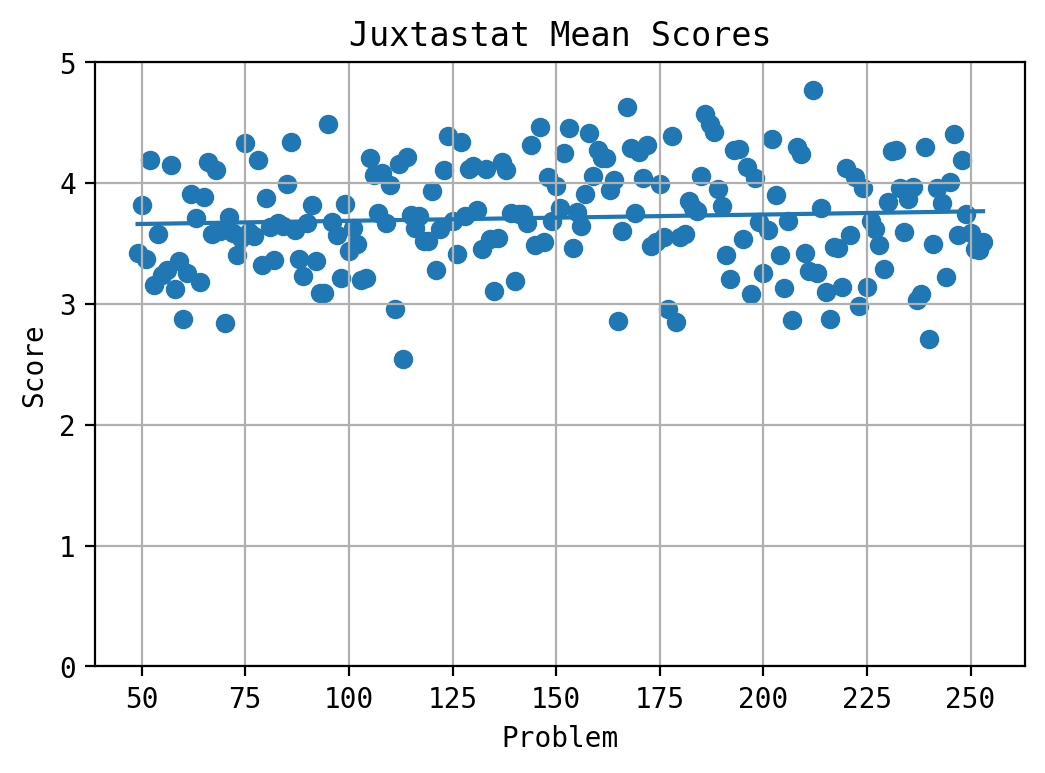

In [21]:
plt.figure(dpi=200, facecolor="white")
plt.title("Juxtastat Mean Scores")
plt.scatter(means.index, means.score)
x = np.array(means.index)[:, None]
lin = sklearn.linear_model.LinearRegression().fit(
    x, means.score
)
[m], b = lin.coef_, lin.intercept_
print(lin.score(x, means.score))
plt.plot(means.index, m * means.index + b)
plt.ylim(0, 5)
plt.xlabel("Problem")
plt.ylabel("Score")
plt.grid()

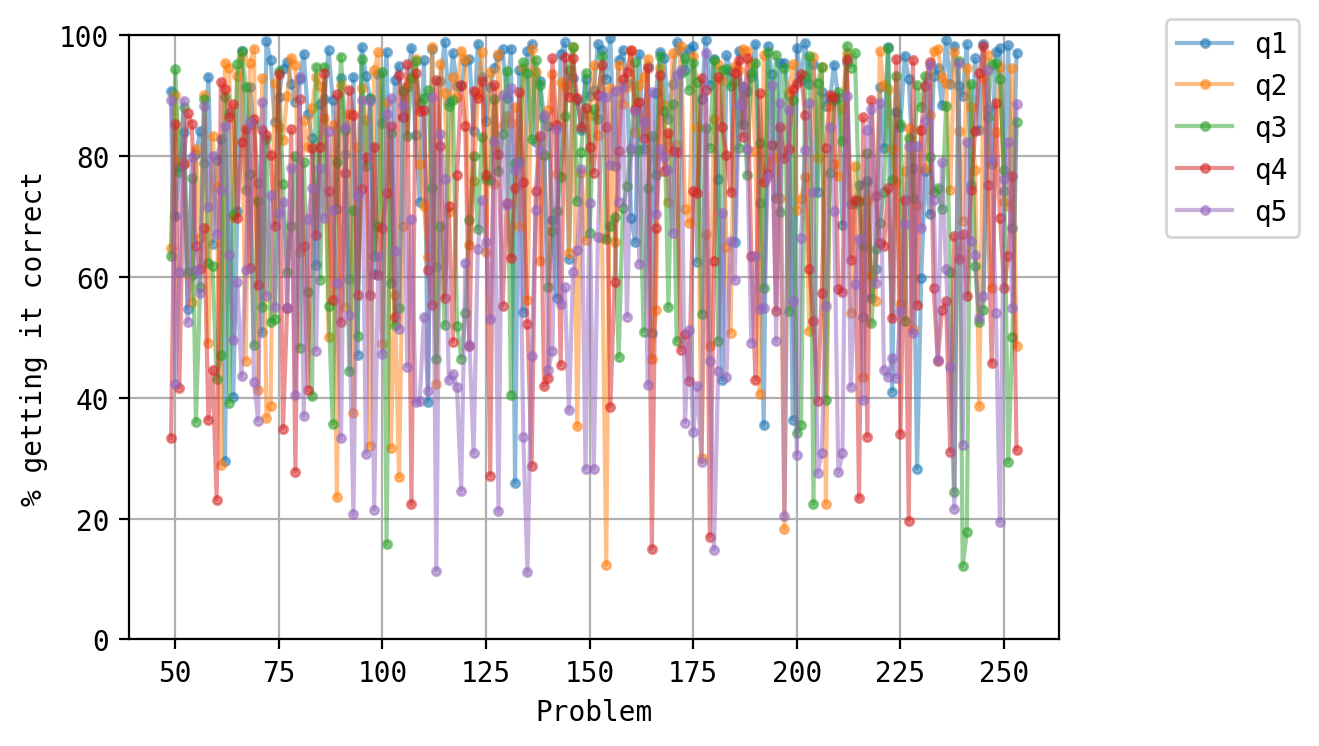

In [22]:
plt.figure(dpi=200)
for q in questions:
    plt.plot(means.index, 100 * means[q], label=q, marker=".", alpha=0.5)
plt.ylim(0, 100)
plt.xlabel("Problem")
plt.ylabel("% getting it correct")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

In [23]:
from datetime import timedelta
import pandas as pd

In [24]:
flat_qs = pd.DataFrame(
    dict(
        correct=np.concatenate([means[question] for question in questions]),
        problem=np.concatenate([means[question].index for question in questions]),
        idx=np.concatenate(
            [
                np.zeros_like(means[question], dtype=np.long) + i
                for i, question in enumerate(questions)
            ]
        ),
    )
).sort_values("correct")
flat_qs["count"] = np.array(result.groupby("problem").count().user_id[flat_qs.problem])

<ipython-input-24-b88779aa24e0>:7: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.zeros_like(means[question], dtype=np.long) + i


In [25]:
def display_row(row):
    result = f"{row.correct:.0%} correct."
    result += f" Juxtastat {row.problem:.0f} q{row.idx + 1:.0f}\n"
    with open(f"/home/kavi/temp/site/quiz/{row.problem:.0f}") as f:
        q = json.load(f)[int(row.idx)]
    result += "  " + display_question(q["question"])
    result += "\n    a) " + q["longname_a"]
    result += "\n    b) " + q["longname_b"]
    return result

In [26]:
for i, (_, worst) in enumerate(flat_qs[:5].iterrows(), 1):
    print(f"{i}th worst performance: " + display_row(worst))

1th worst performance: 11% correct. Juxtastat 135 q5
  Which has more hours of sun per day on average? (population weighted)
    a) DC Circuit, USA
    b) 1st Circuit, USA
2th worst performance: 11% correct. Juxtastat 113 q5
  Which has a higher % of people who commute by bike?
    a) 1st Circuit, USA
    b) 10th Circuit, USA
3th worst performance: 12% correct. Juxtastat 240 q3
  Which has a higher mean daily high temperature in summer (population weighted)?
    a) Chula Vista city, California, USA
    b) Columbus city, Ohio, USA
4th worst performance: 12% correct. Juxtastat 154 q2
  Which has a higher population-weighted density (r=1km)?
    a) Webb County, Texas, USA
    b) Onondaga County, New York, USA
5th worst performance: 15% correct. Juxtastat 180 q5
  Which has a higher % of people who commute by bike?
    a) Pinellas County, Florida, USA
    b) Bronx County, New York, USA


In [27]:
for i, (_, worst) in enumerate(flat_qs[::-1][:5].iterrows(), 1):
    print(f"{i}th best performance: " + display_row(worst))

1th best performance: 100% correct. Juxtastat 155 q1
  Which has a higher mean daily high temperature in summer (population weighted)?
    a) Buffalo city, New York, USA
    b) Chandler city, Arizona, USA
2th best performance: 99% correct. Juxtastat 178 q1
  Which has a higher mean daily high temperature (population weighted)?
    a) 5th Circuit, USA
    b) 2nd Circuit, USA
3th best performance: 99% correct. Juxtastat 236 q1
  Which has a higher % of people who are White?
    a) New Hampshire, USA
    b) Hawaii, USA
4th best performance: 99% correct. Juxtastat 72 q1
  Which has a higher % of hot days (days with high temp over 90°F, population weighted)?
    a) York County, Pennsylvania, USA
    b) Bell County, Texas, USA
5th best performance: 99% correct. Juxtastat 115 q1
  Which has a higher mean daily high temperature in spring (population weighted)?
    a) Rapid City SD Media Market, USA
    b) Laredo TX Media Market, USA


In [28]:
result_time_relevant = result[result.last_in_batch == 1]

In [29]:
count_by_user_id = result_time_relevant.groupby("user_id").count().time
users = count_by_user_id.index[count_by_user_id > 5]

(array([4.2293e+04, 6.0900e+02, 2.5300e+02, 1.5000e+02, 8.3000e+01,
        5.2000e+01, 5.3000e+01, 3.8000e+01, 4.1000e+01, 4.5000e+01]),
 array([  1. ,  21.3,  41.6,  61.9,  82.2, 102.5, 122.8, 143.1, 163.4,
        183.7, 204. ]),
 <BarContainer object of 10 artists>)

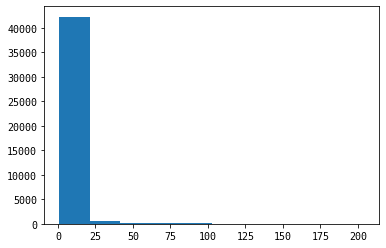

In [30]:
plt.hist(count_by_user_id)

In [31]:
def count_in_range(start, end):
    return result_time_relevant[
        (start < result_time_relevant.time) & (result_time_relevant.time < end)
    ].shape[0]

In [32]:
s = 10

In [33]:
by_user = {}
for user in users:
    before = after = 0
    for t in result_time_relevant[result_time_relevant.user_id == user].time:
        before += count_in_range(t - timedelta(minutes=s), t)
        after += count_in_range(t, t + timedelta(minutes=s))
    if after - before > 10:
        by_user[user] = after / before

In [34]:
by_ratio = pd.DataFrame(dict(ratio=by_user)).sort_values("ratio")[::-1]

In [35]:
result_full = get_full_statistics(after_problem=1, debug=False)

/home/kavi/census-centroid-blocks/population_density/urbanstats/games/quiz_analysis.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.idxmax is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result.loc[result.groupby("time").idxmax().problem, "last_in_batch"] = 1


In [36]:
named_users = dict(
    vo=1000233398257748901,
    avery=1027246234047181785,
    kavi=225074120239201340,
    guava=533487794723891791,
    parth=232188494395851367,
    gus=65416843712317322,
    adiastra=727538863697858149,
    ellie=691958428450574907,
    sleepy=1010706284663446152,
    antifa=1128140214864259863,
    ashjubilee=846814263642105530,
)

In [37]:
def query(*days_patterns):
    result = [
        result_full[
            (result_full.problem == day)
            & (result_full.pattern.apply(lambda x: x.tolist() == pattern))
        ].user_id
        for day, pattern in days_patterns
    ]
    result = [set(x) for x in result]
    from collections import Counter
    ctr = Counter(x for xs in result for x in xs)
    ctr = sorted(ctr.items(), key=lambda x: -x[1])
    return [(id, c - len(days_patterns), c / len(days_patterns)) for id, c in ctr]

In [38]:
count_by_user_id_full = result_full.groupby("user_id").count().time

In [39]:
gaps = []
for uid in tqdm.tqdm(sorted(set(count_by_user_id_full.index[count_by_user_id_full > 1]))):
    days = np.array(sorted(set(result_full[result_full.user_id == uid].problem)))
    gaps += [(days[1:] - days[:-1]).max()]

  0%|          | 0/11165 [00:00<?, ?it/s]

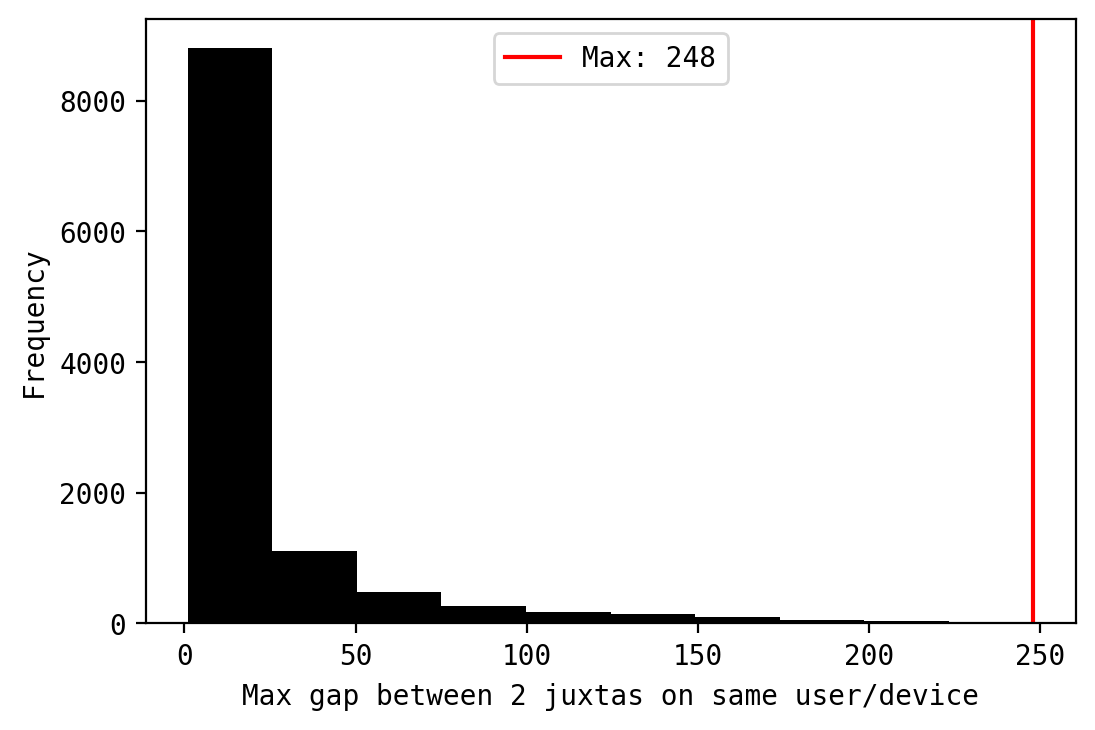

In [40]:
plt.figure(dpi=200, facecolor="white")
plt.hist(gaps, color="black")
plt.xlabel("Max gap between 2 juxtas on same user/device")
plt.ylabel("Frequency")
plt.axvline(max(gaps), label=f"Max: {max(gaps)}", color="red")
plt.legend()
plt.show()

In [41]:
distro = (
    result_full[np.array(count_by_user_id_full[result_full.user_id] > 10)]
    .groupby("user_id")
    .mean()
    .score
)

<ipython-input-41-cb62516042a3>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result_full[np.array(count_by_user_id_full[result_full.user_id] > 10)]


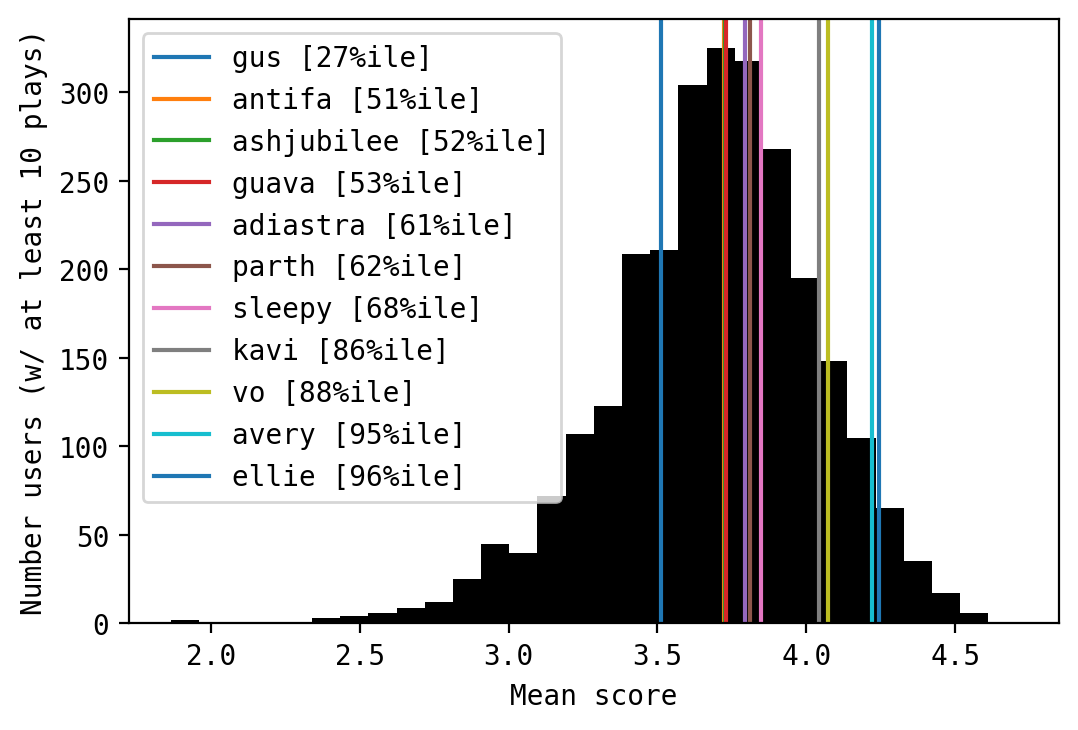

In [42]:
plt.figure(dpi=200, facecolor="white")
plt.hist(distro, bins=30, color="black")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 10
for k, color in zip(sorted(named_users, key=lambda x: distro[named_users[x]]), colors):
    plt.axvline(
        distro[named_users[k]],
        label=f"{k} [{(distro < distro[named_users[k]]).mean() * 100:.0f}%ile]",
        color=color,
    )
plt.xlabel("Mean score")
plt.ylabel("Number users (w/ at least 10 plays)")
plt.legend()
plt.show()

In [43]:
(result_full.score == 5).groupby(result_full.problem).mean().sort_values()[::-1][:10] * 100

problem
212    83.362085
6      75.172414
167    72.153635
186    66.942149
187    63.624339
95     60.700876
10     58.904110
188    56.567164
146    56.441718
153    56.299841
Name: score, dtype: float64

In [44]:
lefts, rights = 0, 0
lefts_bad, rights_bad = 0, 0
for problem in sorted(set(result_full.problem)):
    if problem < 100:
        continue
    with open(f"/home/kavi/temp/site/quiz/{problem}") as f:
        q = json.load(f)
        left_correct = np.array([x["stat_a"] > x["stat_b"] for x in q])
    for_p = result_full[result_full.problem == problem]
    overall_correct = np.array(for_p[questions].sum())
    lefts += overall_correct[left_correct].sum()
    rights += overall_correct[~left_correct].sum()
    lefts_bad += (for_p.shape[0] - overall_correct)[left_correct].sum()
    rights_bad += (for_p.shape[0] - overall_correct)[~left_correct].sum()
#     count += 1
# left_correct /= count
# overall_correct /= count